In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import fusion
import time
import numpy as np

mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['lines.color'] = 'r'

In [10]:
data = []
with open("gyro.dat",'r') as f:
        for line in f:
            result = re.findall(r"-?\d+.\d+", line)
            if len(result) == 10:
                data.append([float(x) for x in result])

In [11]:
def start_angle(a):
    norm = sum(a ** 2) ** 0.5
    a = a / norm
    ψ = np.arcsin(a[0])
    ϕ = np.arctan2(a[1], a[2])
    return ψ, ϕ
    

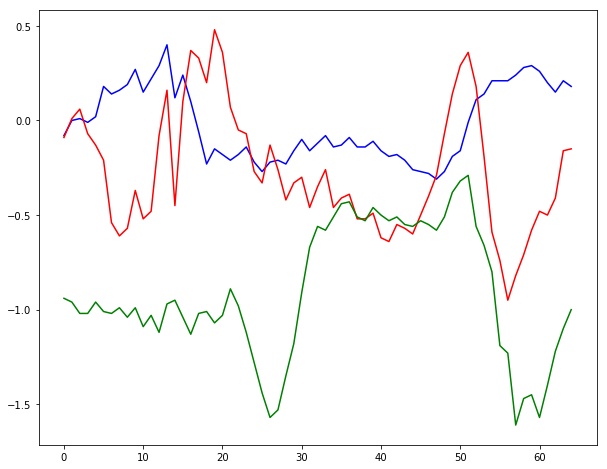

In [4]:
plt.plot([x[1] for x in data], color='b')
plt.plot([x[2] for x in data], color='r')
plt.plot([x[3] for x in data], color='g')
plt.show()

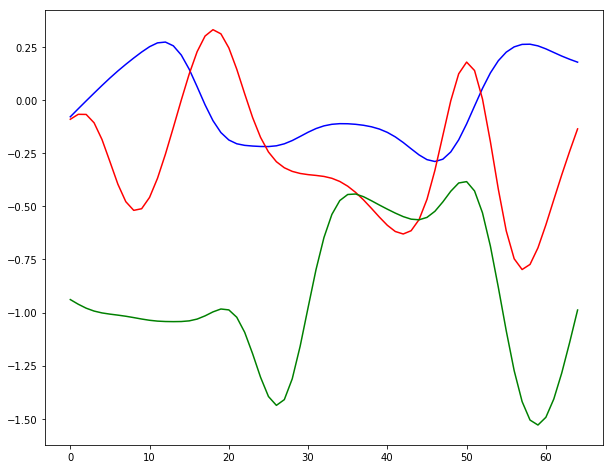

In [5]:
def signal_filter(data, x1, x2):
    data = data.transpose()
    res = np.zeros_like(data)
    for i, x in enumerate(data):
        b, a = signal.butter(x1, x2)
        y = signal.filtfilt(b, a, x)
        res[i] = y
    return res.transpose()

filt_a = signal_filter(np.array(data)[:, 1:4], 3, 0.2)
plt.plot([x[0] for x in filt_a], color='b')
plt.plot([x[1] for x in filt_a], color='r')
plt.plot([x[2] for x in filt_a], color='g')
plt.show()

In [6]:
pitch, roll = start_angle(np.array(data[0][1:4]))
fusioner = fusion.Fusion(roll=roll, pitch=pitch)
dtime = 0.02
angles = []
for a in data:
    fusioner.update_nomag(dtime, (a[1], a[2], a[3]), (a[4], a[5], a[6]))
    #fusioner.update_nomag(a[0], (a[1], a[2], a[3]), filtered_g)
    angles.append([fusioner.pitch, fusioner.heading, fusioner.roll])
angles[0] = angles[1]

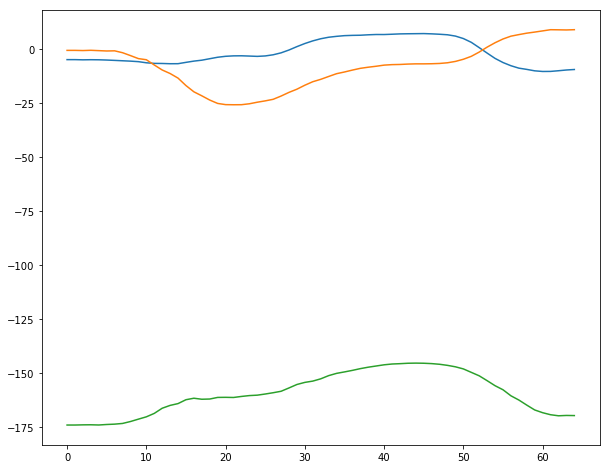

In [7]:
plt.plot([x[0] for x in angles])
plt.plot([x[1] for x in angles])
plt.plot([x[2] for x in angles])
plt.show()

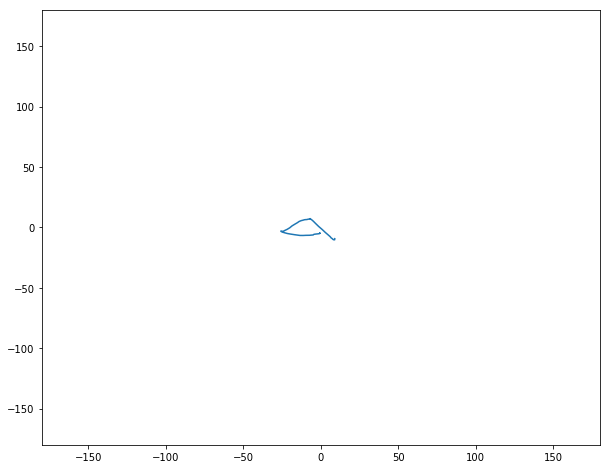

In [8]:
data_x = [x[1] for x in angles]
data_y = [x[0] for x in angles]
plt.plot([x[1] for x in angles], [x[0] for x in angles])
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.show()

In [9]:
a_main = np.zeros((len(filt_a), 3))
for i in range(len(filt_a)):
    x = filt_a[i]
    a = np.array([[x[0]], [x[1]], [x[2]]])
    ang = angles[i]
    a_main[i] = (fusion.rotation_matrix(ang[0], ang[1], ang[2]).dot(a)).transpose()
    a_main[i][2] -= 1

def average(data_xyz):
    data = data_xyz.transpose()
    for i, x in enumerate(data):
        data[i] = x - np.mean(x)        
    return data.transpose()


a_main = average(a_main)


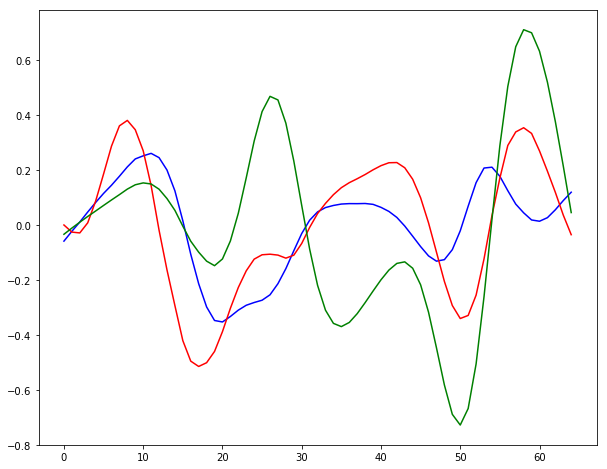

In [10]:
plt.plot([x[0] for x in a_main], color='b')
plt.plot([x[1] for x in a_main], color='r')
plt.plot([x[2] for x in a_main], color='g')
plt.show()

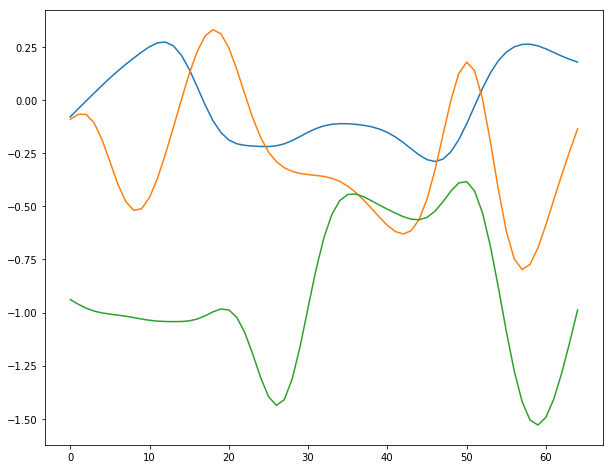

In [11]:
for i in range(1, 4):
    x = [x[i] for x in data]
    b, a = signal.butter(3, 0.2)
    y = signal.filtfilt(b, a, x)
    plt.plot(y)
    
plt.show()

In [12]:
fusion.rotation_matrix(*angles[20])

array([[ 0.89997858, -0.39315945,  0.18831942],
       [-0.43218046, -0.86124984,  0.26733643],
       [ 0.05708422, -0.32198503, -0.94502224]])

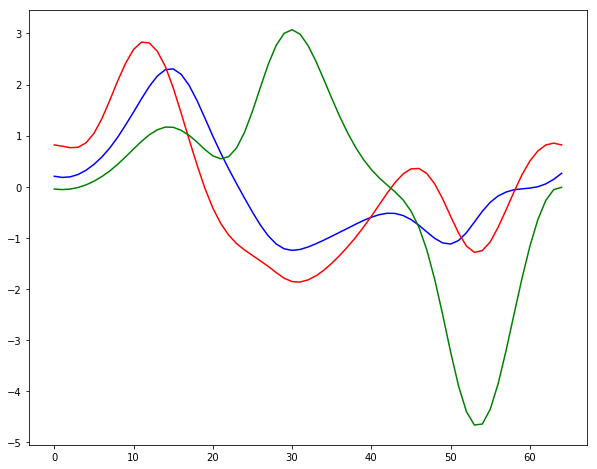

In [15]:
def integrate(a):
    v = np.zeros_like(a)
    for i in range(1, len(a)):
        v[i] = v[i - 1] + a[i]
    return v

v_main = average(integrate(a_main))
x_main = integrate(v_main)
plt.plot([x[0] for x in v_main], color='b')
plt.plot([x[1] for x in v_main], color='r')
plt.plot([x[2] for x in v_main], color='g')
plt.show()

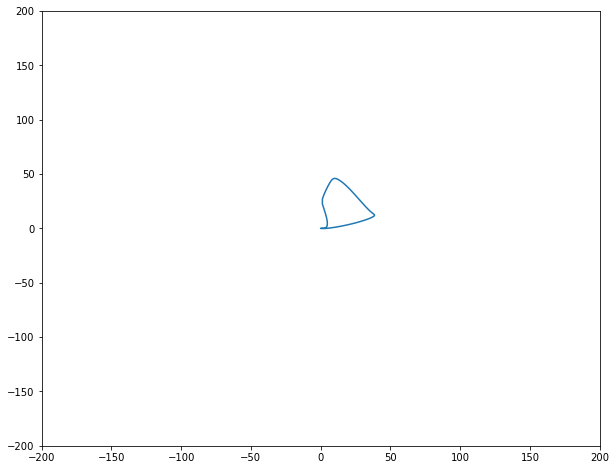

In [16]:
data_x = [x[1] for x in x_main]
data_y = [x[0] for x in x_main]
plt.plot([(x[0] ** 2 + x[1] ** 2) ** 0.5 for x in x_main], [x[2] for x in x_main])
plt.ylim(-200, 200)
plt.xlim(-200, 200)
plt.show()